In [407]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import GaussianNB

# 1. upload data sets, and convert to pandas data frames
country_stats_data = pd.read_csv("country_happiness_report.csv")
all_int_football_results = pd.read_csv("all_int_football_results.csv")
historic_wc_top_three = pd.read_csv("historical_world_cup_top_three.csv")
fifa_players_data = pd.read_csv("fifa_players.csv")

# 2. clean data.
# replace missing values by mean of set, given attribute and data set.
# replace missing values by mode of set, given attribute and data set.
# given attrs to keep in the set, trim set.
# aggregate to provide clarity when relevant
# organize existing data into meaningful data frames.


In [2]:
# extra dataset not yet needed
# TODO: delete this if we won't use it.
# historic_wc_games_data = pd.read_csv("historical_world_cup_final_bracket_games.csv")

In [3]:
# fifa_players_data
# data cleaning
# minimize attributes used.
# fill national team based on nationality if value is null.
# fill numeric missing values with mean.
# fill categorical missing values with mode.
# normalize attribute values that are numeric for consistency in correlation
# sort players by overall rating.
top_player_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'positions',
    'value_euro',
    'wage_euro',
    'preferred_foot',
    'international_reputation(1-5)',
    'body_type',
    'national_team', # use nationality if na
]
top_player_fill_mean_attrs = [
    'overall_rating',
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
]
top_player_fill_mode_attrs = [
    'preferred_foot',
    'body_type',
]

selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_attrs]
fifa_top_players_data = fifa_players_data[selected_attrs_cols]
fifa_top_players_data['national_team'] = fifa_players_data.national_team.fillna(fifa_top_players_data['nationality'])
# data cleaning - fill by means and modes based on attr set.
fifa_top_players_data[top_player_fill_mean_attrs] = fifa_top_players_data[top_player_fill_mean_attrs].transform(lambda x: x.fillna(x.mean()))
fifa_top_players_data[top_player_fill_mode_attrs] = fifa_top_players_data[top_player_fill_mode_attrs].transform(lambda x: x.fillna(x.mode()))

# normalize numeric attr values
top_player_subset_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
# create a subset data table for player skills
top_player_skill_attrs = [attr for attr in top_player_subset_attrs if attr is not 'full_name' and attr is not 'nationality' ]
selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_subset_attrs]

fifa_top_players_skills_data = fifa_players_data[selected_attrs_cols]
# normalize
fifa_top_players_skills_data[top_player_skill_attrs] = fifa_top_players_skills_data[top_player_skill_attrs].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
# fifa_top_players_data
fifa_top_players_skills_data.sort_values(by=['overall_rating'], inplace=True, ascending=False)
fifa_top_players_skills_data.head()

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

,full_name,nationality,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,ball_control,acceleration,sprint_speed,agility,reactions,shot_power,jumping,stamina,strength,long_shots
0,Lionel Andrés Messi Cuccittini,Argentina,1.000000,0.920455,1.000000,0.733333,0.988372,0.954023,1.000000,0.988636,...,1.000000,0.929412,0.880952,0.964706,0.986111,0.892473,0.6625,0.705882,0.597403,1.000000
17944,Cristiano Ronaldo dos Santos Aveiro,Portugal,1.000000,0.897727,0.989247,0.944444,0.860465,0.965517,0.903226,0.852273,...,0.978022,0.905882,0.940476,0.894118,1.000000,1.000000,1.0000,0.894118,0.766234,0.989011
17943,Neymar da Silva Santos Junior,Brazil,0.957447,0.886364,0.913978,0.644444,0.895349,0.931034,0.989247,0.931818,...,0.989011,0.964706,0.928571,1.000000,0.972222,0.838710,0.5750,0.811765,0.376623,0.868132
17939,Luka Modrić,Croatia,0.936170,0.920455,0.752688,0.566667,1.000000,0.839080,0.924731,0.897727,...,0.956044,0.800000,0.714286,0.952941,0.916667,0.827957,0.6625,0.905882,0.493506,0.868132
17942,David De Gea Quintana,Spain,0.936170,0.136364,0.118280,0.188889,0.500000,0.114943,0.150538,0.170455,...,0.362637,0.529412,0.547619,0.600000,0.916667,0.311828,0.6500,0.364706,0.571429,0.098901


In [4]:
# historic_wc_top_three
# organize historical world cup data by country
# aggregate records in terms of number of times finishing in a given place in final four
# fill na with 0
# add column for sum of total QF appearances
# rename some columns so there is clearly First, Second, Third, Fourth 

finishes = ['Winner', 'Runners-Up', 'Third', 'Fourth']

wc_hist_perf_summary = pd.DataFrame(data=historic_wc_top_three['Country'])
for finish in finishes:
    temp_sum = pd.DataFrame()
    temp_sum[finish] = historic_wc_top_three[finish].value_counts()
    temp_sum = temp_sum.rename_axis('Country')
    temp_sum['Country'] = temp_sum.index
    temp_sum.index.rename('test')
    wc_hist_perf_summary = pd.merge(wc_hist_perf_summary,temp_sum, how='left', on="Country", left_index=False, right_index=False)

wc_hist_perf_summary[finishes] = wc_hist_perf_summary[finishes].transform(lambda x: x.fillna(0)).transform(lambda x: x.astype(int))
wc_hist_perf_summary['Sum QF Appearances'] = wc_hist_perf_summary.sum(axis=1)
wc_hist_perf_summary = wc_hist_perf_summary.rename(columns={'Runners-Up': 'Second', 'Winner': 'First'})
wc_hist_perf_summary

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: FutureWarning: 'Country' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,Country,First,Second,Third,Fourth,Sum QF Appearances
0,Uruguay,2,0,0,3,5
1,Italy,4,2,1,1,8
2,France,1,1,2,1,5
3,Brazil,5,2,2,2,11
4,Switzerland,0,0,0,0,0
5,Sweden,0,1,2,1,4
6,Chile,0,0,1,0,1
7,England,1,0,0,1,2
8,Mexico,0,0,0,0,0
9,Germany,1,1,3,0,5


In [5]:
# historic_wc_top_three
# aggregate top finishes for each country using aggregated data on qf finishes (only including qf finishes)
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']

def find_top_finish_in_qf(row):
    # print(row['Country'])
    country = row['Country']
    finishes = wc_hist_perf_summary.loc[wc_hist_perf_summary['Country'] == country]
    top_finish = 0
    first = (finishes.First).all()
    second = (finishes.Second).all()
    third = (finishes.Third).all()
    fourth = (finishes.Fourth).all()
    if (first):
        top_finish = 1
    elif (second):
        top_finish = 2
    elif (third):
        top_finish = 3
    elif (fourth):
        top_finish = 4
    return top_finish

top_finishes_in_qf = pd.DataFrame(data=wc_hist_perf_summary['Country'])
top_finishes_in_qf['top finish'] = top_finishes_in_qf.apply(lambda x: find_top_finish_in_qf(x), axis=1)
top_finishes_in_qf

,Country,top finish
0,Uruguay,1
1,Italy,1
2,France,1
3,Brazil,1
4,Switzerland,0
5,Sweden,2
6,Chile,3
7,England,1
8,Mexico,0
9,Germany,1


In [6]:
# minimize, clean, and aggregate country happiness data
# minimize number of attributes in set
# select a number of years for each country using broundaries.
# TODO: add a row for a year not present based on mean.
# find the mean for each country
# TODO: remove years column
# for data with NAN values, data was NaN for all values in country.  Update with mean from column.
selected_attrs_country = [
    'country',
    'year', 
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

attrs_for_cleaning_nans = [
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

# minimize data set
selected_attrs_cols = [col for col in country_stats_data.columns if col in selected_attrs_country]
country_data = country_stats_data[selected_attrs_cols]

# set date boundaries 
start_remove = 2014
end_remove = 2016
# group data by country and use mean for group override NAN with mean.
for attr in attrs_for_cleaning_nans:
    country_data[attr] = country_data.groupby('country', as_index=False)[attr].transform(lambda x: x.fillna(x.mean()))

# filter for years in boundaries
country_data = country_data.loc[(country_data.year >= start_remove) & (country_data.year <= end_remove)]
# get mean for country over years
country_data = country_data.groupby('country', as_index=False)[selected_attrs_cols].mean()
# remaining NaNs are because data was NaN for all values in country.  replace these with mean from column.
country_data = country_data.fillna(country_data.mean())
country_data.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,Afghanistan,2015.0,3.777973,7.507917,0.537746,49.588539,0.473336,0.090321,0.550066,0.354156,0.331531,-1.895385,0.281074
1,Albania,2015.0,4.643838,9.251357,0.634452,68.531487,0.722773,-0.041561,0.682841,0.335558,0.468892,0.116744,0.126247
2,Algeria,2015.0,5.871535,9.531784,0.783170,64.624016,0.569640,-0.212148,0.647371,0.274119,0.472700,-1.085674,0.233018
3,Angola,2014.0,3.794838,8.847354,0.754615,45.092995,0.374542,-0.164495,0.578517,0.367864,0.572346,-0.705554,0.233018
4,Argentina,2015.0,6.598489,9.658498,0.909061,67.291908,0.824661,-0.131493,0.852525,0.284971,0.402231,0.166956,0.199123


In [7]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_2018 = fifa_wc_results.loc[all_int_football_results['date'].str.contains('2018')]

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_2018['winner'] = fifa_wc_results_2018.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_2018_winners = fifa_wc_results_2018.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_2018_winners = pd.DataFrame(fifa_wc_results_2018_winners)
fifa_wc_results_2018_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
fifa_wc_results_2018_winners.head()


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,winner,num_wins
26,tie,13
1,Belgium,6
7,France,6
4,Croatia,4
25,Uruguay,4


In [8]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_all_time = fifa_wc_results

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_all_time['winner'] = fifa_wc_results_all_time.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_all_time_winners = fifa_wc_results_all_time.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_all_time_winners = pd.DataFrame(fifa_wc_results_all_time_winners)
fifa_wc_results_all_time_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
fifa_wc_results_all_time_winners.head()

/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,winner,num_wins
62,tie,199
6,Brazil,73
21,Germany,67
26,Italy,45
1,Argentina,43


In [9]:
# join simple soccer 2018 wc wins and country data set
merged_2018_wc_wins_and_happiness_by_country = pd.merge(left=fifa_wc_results_2018_winners,right=country_data, left_on='winner', right_on='country')
m_a_h_c_2018 = merged_2018_wc_wins_and_happiness_by_country.drop(['winner'], axis=1)
m_a_h_c_2018 = m_a_h_c_2018.rename(columns={"num_wins": "total wc wins of country"})
m_a_h_c_2018.head()

,total wc wins of country,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,6,Belgium,2015.0,6.902828,10.624256,0.919241,71.521675,0.865396,-0.006026,0.789134,0.250390,0.449104,1.075157,0.306121
1,6,France,2015.0,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650
2,4,Croatia,2014.5,5.293065,9.914950,0.707031,67.503502,0.606201,0.013581,0.602532,0.289957,0.259938,0.538784,0.206280
3,4,Uruguay,2015.0,6.453670,9.900286,0.897924,68.120193,0.902528,-0.072871,0.867820,0.278072,0.523013,0.990709,0.277648
4,3,Sweden,2015.0,7.298938,10.718898,0.924747,71.961449,0.932794,0.172794,0.823103,0.199762,0.516122,1.371415,0.562753


In [10]:
# datasets
# top players skills, in order of rank.
fifa_top_players_skills_data.head()
# world cup performance summary for each country, showing number of times they finished in the top four and sum of 
# all qf appearances, historically.
wc_hist_perf_summary.head()
# top finish for a country who has played in a WC quarter final match.
top_finishes_in_qf.head()
# country data happiness
country_data.head()
# 2018 wc number of wins for top countries (excluding 2018)
fifa_wc_results_2018_winners.head()
# total number of matches won by each countries in all world cups, historically (excluding 2018)


,winner,num_wins
26,tie,13
1,Belgium,6
7,France,6
4,Croatia,4
25,Uruguay,4


In [11]:
# merged test:
# merged_2018_wc_wins_and_happiness_by_country.head()

In [12]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.
fifa_wc_winners_and_country_happiness = pd.merge(left=fifa_wc_results_all_time_winners,right=country_data, left_on='winner', right_on='country')
fifa_wc_winners_and_country_happiness = fifa_wc_winners_and_country_happiness.drop(['year', 'winner'], axis=1)
fifa_wc_winners_and_country_happiness.head()

,num_wins,country,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,73,Brazil,6.634238,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
1,67,Germany,6.965038,10.693012,0.923170,70.863174,0.886209,0.126598,0.762565,0.192602,0.593995,1.151189,0.315909
2,45,Italy,5.942931,10.422762,0.911366,72.727562,0.607346,-0.076797,0.697753,0.341467,0.269087,0.730997,0.207117
3,43,Argentina,6.598489,9.658498,0.909061,67.291908,0.824661,-0.131493,0.852525,0.284971,0.402231,0.166956,0.199123
4,34,France,6.433234,10.527748,0.886049,72.462580,0.802430,-0.126228,0.789894,0.233777,0.292011,0.851397,0.198650


In [13]:
fifa_top_players_skills_and_country_happiness = pd.merge(left=fifa_top_players_skills_data,right=country_data, left_on='nationality', right_on='country')

f_t_p_s_c_h_a_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_and_country_happiness, left_on='winner', right_on='country')
f_t_p_s_c_h_a_wins = f_t_p_s_c_h_a_wins.drop(['winner'], axis=1)
fifa_top_players_skills_and_country_happiness = f_t_p_s_c_h_a_wins.rename(columns={"num_wins": "wc_wins_for_country"})
fifa_top_players_skills_and_country_happiness.head()

,wc_wins_for_country,full_name,nationality,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,73,Neymar da Silva Santos Junior,Brazil,0.957447,0.886364,0.913978,0.644444,0.895349,0.931034,0.989247,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
1,73,Philippe Coutinho Correia,Brazil,0.872340,0.840909,0.827957,0.488889,0.930233,0.827586,0.935484,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
2,73,Thiago Emiliano da Silva,Brazil,0.872340,0.625000,0.387097,0.855556,0.848837,0.689655,0.623656,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
3,73,Carlos Henrique Venancio Casimiro,Brazil,0.851064,0.602273,0.666667,0.800000,0.883721,0.666667,0.698925,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
4,73,Marcelo Vieira da Silva Júnior,Brazil,0.851064,0.965909,0.763441,0.788889,0.895349,0.666667,0.924731,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043


In [14]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.

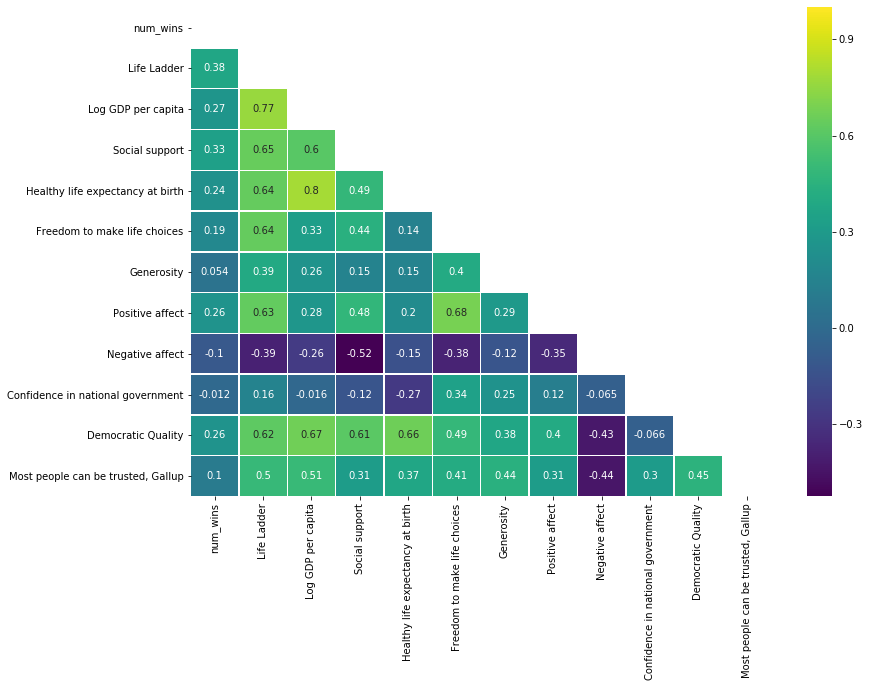

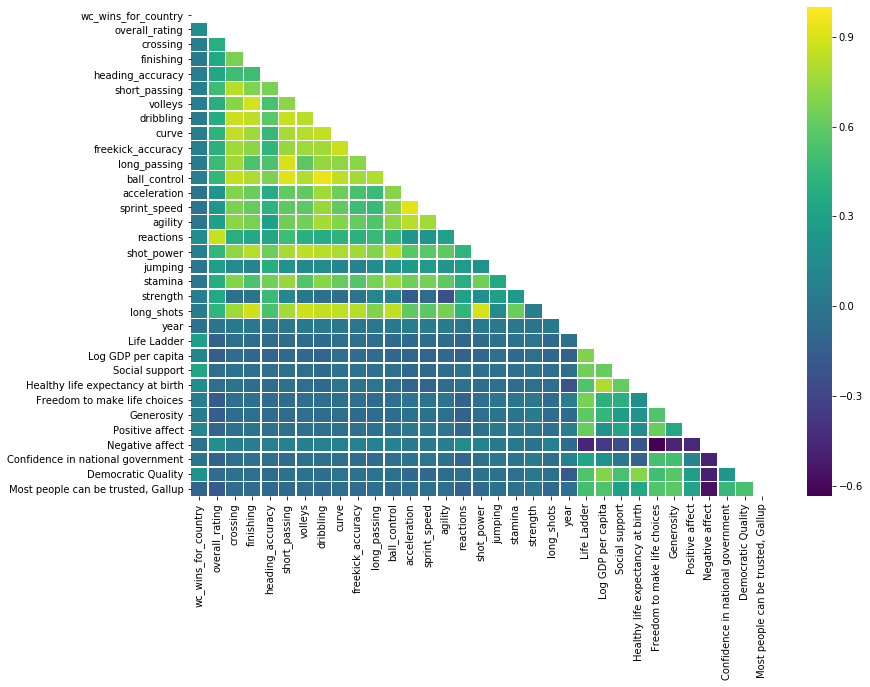

In [15]:
# If you have a lot of variables, you can use the pandas.DataFrame method corr() 
# to calculate a correlation matrix that shows the correlation coefficient for each pair of variables.
# correlated_fifa_winners_and_national_happiness
def create_correlation_heatmap(dataset, show_corr_nums):
    c_f_w_a_n_p = dataset.corr()
    mask = np.zeros_like(c_f_w_a_n_p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(13, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(c_f_w_a_n_p, vmax=1., annot=show_corr_nums, mask=mask, linewidths=.5, cmap="viridis")
    
create_correlation_heatmap(fifa_wc_winners_and_country_happiness, True)
create_correlation_heatmap(fifa_top_players_skills_and_country_happiness, False)


In [16]:
import scipy.stats
def log_correlation_to_wins(dataframe, comparison_attr, comparison_set):
    my_panda = pd.DataFrame()
    for attr in comparison_set:
        x = dataframe[comparison_attr]
        y = dataframe[attr]
        z = scipy.stats.pearsonr(x.values,y.values)[0]

        a = y.corr(x)
        my_panda.at[attr, 'Pearsons'] = z
        my_panda.at[attr, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda

skills = [
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots',
]

def log_correlation_multi(dataframe):
    my_panda = pd.DataFrame()
    for hap_attr in attrs_for_cleaning_nans:
        for plyr_skill in skills:
            x = dataframe[plyr_skill]
            y = dataframe[hap_attr]
            z = scipy.stats.pearsonr(x.values,y.values)[0]

            a = y.corr(x)
            row_name = plyr_skill + ', ' + hap_attr
            my_panda.at[row_name, 'Pearsons'] = z
            my_panda.at[row_name, 'Corr'] = a

    my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
    return my_panda

log_correlation_to_wins(fifa_wc_winners_and_country_happiness, 'num_wins', attrs_for_cleaning_nans)

,Pearsons,Corr
Life Ladder,0.379623,0.379623
Social support,0.333573,0.333573
Log GDP per capita,0.272708,0.272708
Democratic Quality,0.260263,0.260263
Positive affect,0.257264,0.257264
Healthy life expectancy at birth,0.243334,0.243334
Freedom to make life choices,0.188992,0.188992
"Most people can be trusted, Gallup",0.104028,0.104028
Generosity,0.053956,0.053956
Confidence in national government,-0.012465,-0.012465


In [17]:

log_correlation_multi(fifa_top_players_skills_and_country_happiness)

,Pearsons,Corr
"overall_rating, Negative affect",0.181659,0.181659
"reactions, Negative affect",0.150565,0.150565
"freekick_accuracy, Negative affect",0.081725,0.081725
"ball_control, Negative affect",0.081226,0.081226
"long_shots, Negative affect",0.079486,0.079486
"curve, Negative affect",0.076571,0.076571
"short_passing, Negative affect",0.076569,0.076569
"dribbling, Negative affect",0.076070,0.076070
"shot_power, Negative affect",0.075436,0.075436
"long_passing, Negative affect",0.072409,0.072409


In [18]:
log_correlation_to_wins(fifa_top_players_skills_and_country_happiness, 'wc_wins_for_country', skills)

,Pearsons,Corr
overall_rating,0.163573,0.163573
reactions,0.160147,0.160147
freekick_accuracy,0.065393,0.065393
short_passing,0.061723,0.061723
heading_accuracy,0.059315,0.059315
shot_power,0.059123,0.059123
ball_control,0.057134,0.057134
curve,0.055612,0.055612
volleys,0.055565,0.055565
crossing,0.050161,0.050161


In [19]:
# group things with top ranked countries into sets to find similarities.
fifa_top_players_skills_and_country_happiness.head()

,wc_wins_for_country,full_name,nationality,overall_rating,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,...,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Positive affect,Negative affect,Confidence in national government,Democratic Quality,"Most people can be trusted, Gallup"
0,73,Neymar da Silva Santos Junior,Brazil,0.957447,0.886364,0.913978,0.644444,0.895349,0.931034,0.989247,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
1,73,Philippe Coutinho Correia,Brazil,0.872340,0.840909,0.827957,0.488889,0.930233,0.827586,0.935484,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
2,73,Thiago Emiliano da Silva,Brazil,0.872340,0.625000,0.387097,0.855556,0.848837,0.689655,0.623656,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
3,73,Carlos Henrique Venancio Casimiro,Brazil,0.851064,0.602273,0.666667,0.800000,0.883721,0.666667,0.698925,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043
4,73,Marcelo Vieira da Silva Júnior,Brazil,0.851064,0.965909,0.763441,0.788889,0.895349,0.666667,0.924731,...,9.576959,0.905822,64.589249,0.773107,-0.088033,0.768845,0.300108,0.272635,0.178093,0.144043


In [20]:
fifa_top_players_skills_and_country_happiness.head()
a = fifa_top_players_skills_and_country_happiness
a.head()
y = a['overall_rating'].mean()
b = df1 = a[a['overall_rating'].astype(float) > y]
def filter_for_significance(pandaset, include_only_wins):
    dataset_list = []
    for index, row in pandaset.iterrows(): 
        dataset_row = []
        is_winning_country = False
        for col in pandaset.columns:
            if type(row[col]) is float or type(row[col]) is int:
                col_mean = pandaset[col].mean()
                if row[col] > col_mean:
                    if (col is 'wc_wins_for_country'):
                        is_winning_country = True
                    dataset_row.append(col)
        if include_only_wins:
            if is_winning_country is True:
                dataset_list.append(dataset_row)
        else:
            dataset_list.append(dataset_row)
    return dataset_list

def set_up_for_apriori(data_list):
    te = TransactionEncoder()
    te_ary = te.fit(data_list).transform(data_list)
    return pd.DataFrame(te_ary, columns=te.columns_)


In [21]:
significance_including_only_winners = set_up_for_apriori(filter_for_significance(a, True))

In [57]:
# significance_including_only_winners.head()

In [22]:
significance_no_secondary_filter = set_up_for_apriori(filter_for_significance(a, False))

In [58]:
# significance_no_secondary_filter.head()

In [226]:
# def set_apriori_w_threshold_support(data_list):
#     pd.set_option('display.max_colwidth', -1)
#     frequent_itemsets = apriori(data_list, use_colnames=True)
#     return frequent_itemsets

def filter_for_consequents(data_list, consequent, antecendent_min_len, confidence_min, support_min, lift_min):
    #association_set = association_set[association_set['consequents'].astype(str).str.contains(consequent)]
    pd.set_option('display.max_colwidth', -1)
    freq_itemsets = apriori(data_list, use_colnames=True)
    association_set = association_rules(freq_itemsets, metric="lift", min_threshold=0, support_only=False)
    association_set["antecedent_len"] = association_set["antecedents"].apply(lambda x: len(x))
    association_set = association_set[(association_set['antecedent_len'] >= antecendent_min_len) &
       (association_set['consequents'].astype(str).str.contains(consequent)) &
       (association_set['confidence'] > confidence_min) &
       (association_set['support'] > support_min) &                              
       (association_set['lift'] > lift_min)]
    return association_set


In [227]:
#s_1_frequent_itemsets = set_apriori_w_threshold_support(significance_including_only_winners, .5)
#association_set = association_rules(s_1_frequent_itemsets, metric="lift", min_threshold=0.5, support_only=False)
assoc_rules = filter_for_consequents(
    significance_including_only_winners, 
    # consequent = #
    'wc_wins_for_country', 
    # antecendent_min_len = #
    3, 
    # min support threshold = #,
    .5,
    # confidence_min = #
    0, 
    # lift_min = #
    1)
assoc_rules.head()


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
1189,"(Healthy life expectancy at birth, Log GDP per capita, Social support)","(wc_wins_for_country, Democratic Quality)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1190,"(Log GDP per capita, Social support, Democratic Quality)","(Healthy life expectancy at birth, wc_wins_for_country)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1195,"(Healthy life expectancy at birth, Social support, Democratic Quality)","(Log GDP per capita, wc_wins_for_country)",0.558414,0.711915,0.558414,1.0,1.404662,0.160871,inf,3
1219,"(Healthy life expectancy at birth, ball_control, Log GDP per capita)","(wc_wins_for_country, Democratic Quality)",0.500996,0.711915,0.500996,1.0,1.404662,0.144329,inf,3
1220,"(ball_control, Log GDP per capita, Democratic Quality)","(Healthy life expectancy at birth, wc_wins_for_country)",0.500996,0.711915,0.500996,1.0,1.404662,0.144329,inf,3


In [231]:
# s_2_frequent_itemsets = set_apriori_w_threshold_support(
#     significance_no_secondary_filter)
# association_set_2 = association_rules(s_2_frequent_itemsets, metric="lift", min_threshold=0.5, support_only=False)

x = filter_for_consequents(
    significance_no_secondary_filter, 
    # consequent = #
    'dribbling', 
    # antecendent_min_len = #
    0, 
    # min support threshold = #,
    0,
    # confidence_min = #
    0, 
    # lift_min = #
    0)
x

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
18,(acceleration),(dribbling),0.604412,0.658746,0.526612,0.871280,1.322634,0.128458,2.651131,1
23,(agility),(dribbling),0.562662,0.658746,0.505589,0.898566,1.364055,0.134938,3.364295,1
26,(ball_control),(dribbling),0.666963,0.658746,0.608187,0.911876,1.384260,0.168828,3.872416,1
40,(crossing),(dribbling),0.579466,0.658746,0.526020,0.907767,1.378023,0.144299,3.699912,1
42,(finishing),(dribbling),0.540380,0.658746,0.502480,0.929863,1.411565,0.146506,4.865535,1
44,(long_shots),(dribbling),0.565993,0.658746,0.517729,0.914727,1.388588,0.144883,4.001883,1
46,(short_passing),(dribbling),0.629950,0.658746,0.541787,0.860047,1.305582,0.126810,2.438347,1
48,(shot_power),(dribbling),0.599896,0.658746,0.529869,0.883268,1.340832,0.134690,2.923385,1
50,(sprint_speed),(dribbling),0.609075,0.658746,0.522392,0.857681,1.301991,0.121166,2.397812,1
62,"(short_passing, ball_control)",(dribbling),0.571693,0.658746,0.526020,0.920109,1.396758,0.149419,4.271482,2


In [317]:
# classification.
# Decision Trees and Bayesian Classifier
# merge 2018 WC wins into player dataset.
# look at num_wins in country happiness data
# look at num_wins in player dataset.
# run classification algorithms.
# what characteristics determine win.
# x should be data, y target.

In [412]:
def setUpDataForClassification(data_set, target_column, classified_columns, test_set_size):
    y = data_set[target_column].values.reshape(-1, 1)
    droplist = classified_columns + [target_column]
    X = data_set.drop(droplist, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=test_set_size,random_state=42,
    shuffle=True)
    return x_train, x_test, y_train, y_test

def DTRegressionWrapper(x_train, x_test, y_train, y_test, data_set_name):
    model =  DecisionTreeRegressor(max_depth=5,random_state=0)
    model.fit(x_train, y_train)
    model_score = model.score(x_train,y_train)
    print("DATASET: ", data_set_name)
    print("R^2 : ",model_score)
    y_predicted = model.predict(x_test)
    print('Mean squared error: %.2f'% mean_squared_error(y_test, y_predicted))
    print('Test Variance score: %.2f' % r2_score(y_test, y_predicted))
    return (y_test, y_predicted)

def NaiveBayes(x_train, x_test, y_train, y_test):
    model = GaussianNB()
    y_predicted = model.fit(x_train, y_train).predict(x_test)
    print("Mislabeled of total points %d: %d"
        % (x_train.shape[0],(y_train != y_predicted).sum()))
    return (y_test, y_predicted)

def PlotRegressionFit(y_test, y_predicted, algo_name):
    fig, ax = plt.subplots()
    ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
    ax.plot([y_test_set.min(), y_test_set.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    ax.set_xlabel('Actual from Data')
    ax.set_ylabel('Predicted from Model')
    ax.set_title("Actual vs Predicted from Model: " + algo_name)

DATASET:  fifa_wc_winners_and_country_happiness
R^2 :  0.992292832685128
Mean squared error: 419.68
Test Variance score: -1.67
Mislabeled of total points 34: 550


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


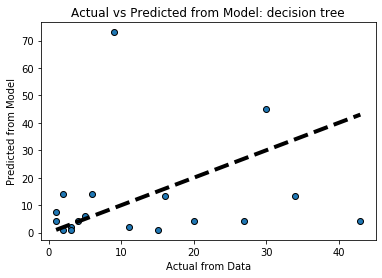

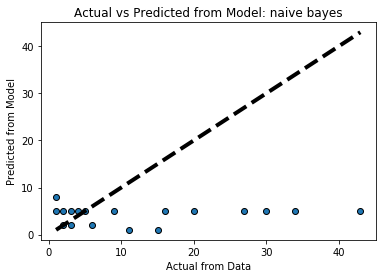

In [413]:
x_train, x_test, y_train, y_test = setUpDataForClassification(
    fifa_wc_winners_and_country_happiness,
    # target_column= #
    'num_wins', 
    # classified_column= #
    ['country'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'fifa_wc_winners_and_country_happiness',)
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')

DATASET:  players_alltime_country_wins
R^2 :  0.06217765786264328
Mean squared error: 442.88
Test Variance score: 0.02
Mislabeled of total points 10730: 53762341


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


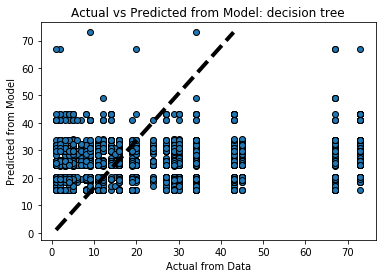

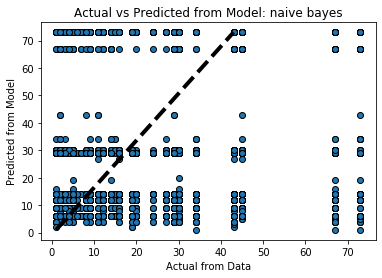

In [414]:
players_alltime_country_wins = pd.merge(left=fifa_wc_results_all_time_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_alltime_country_wins = players_alltime_country_wins.drop(['winner'], axis=1)
players_alltime_country_wins = players_alltime_country_wins.rename(columns={"num_wins": "wc_wins_for_country"})
x_train, x_test, y_train, y_test = setUpDataForClassification(
    players_alltime_country_wins, 
    # target_column= #
    'wc_wins_for_country', 
    # classified_columns= #
    ['nationality', 'full_name'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'players_alltime_country_wins')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')

DATASET:  players_2018_wc_wins
R^2 :  0.047718805763995786
Mean squared error: 2.59
Test Variance score: -0.01
Mislabeled of total points 7382: 15334220


/Users/catherinejohnson/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


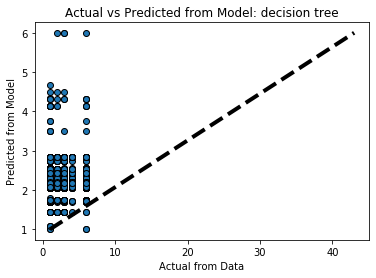

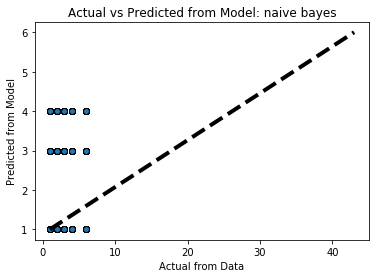

In [415]:
players_2018_wc_wins = pd.merge(left=fifa_wc_results_2018_winners,right=fifa_top_players_skills_data, left_on='winner', right_on='nationality')
players_2018_wc_wins = players_2018_wc_wins.drop(['winner'], axis=1)
players_2018_wc_wins = players_2018_wc_wins.rename(columns={"num_wins": "wc_wins_in_2018"})
x_train, x_test, y_train, y_test = setUpDataForClassification(
    players_2018_wc_wins,
    # target_column= #
    'wc_wins_in_2018', 
    # classified_columns= #
    ['nationality', 'full_name'],
    # test_set_size= #
    .33,
)
y_test_dt, y_predicted_dt = DTRegressionWrapper(
    x_train, 
    x_test, 
    y_train, 
    y_test,
    # data set name = #
    'players_2018_wc_wins')
y_test_nb, y_predicted_nb = NaiveBayes(x_train, x_test, y_train, y_test)
PlotRegressionFit(y_test_dt, y_predicted_dt, 'decision tree')
PlotRegressionFit(y_test_nb, y_predicted_nb, 'naive bayes')

